# Estimating Gestational Diabetes Onset
### Reverse Timeseries Forecasting

## Pre-processing

<ul>
	<li><a href="#Imports"><strong>Imports</strong></a></li>
	<li><a href="#Notebook-Settings"><strong>Notebook Settings</a></li>
	<li><a href="#Load-the-data"><strong>Loading the data</strong></a>
		<ul>
			<li>Setting the index</li>
			<li>Reverse the timeseries</li>
		</ul>
	</li>
    <li><a href="#Visualize"><strong>Visualize</strong></a>
		<ul>
			<li>Seasonal Decompose</li>
		</ul>
	</li>
    <li><a href="#Stationarity"><strong>Stationarity</strong></a>
		<ul>
			<li>Dickey Fuller Test</li>
		</ul>
	</li>
    <li><a href="#ACF-and-PACF"><strong>ACF and PACF</strong></a></li>
    <li><a href="#Finding-ARIMA-Parameters"><strong>Finding ARIMA Parameters</strong></a></li>
</ul>


### Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

from library.sb_utils import save_file
from library.functions import jlcap_test_stationarity
from library.functions import jlcap_optimize_arima

### Notebook Settings

In [2]:
pd.set_option('display.max_rows', 500)

### Load the data

In [3]:
df = pd.read_csv('data/data_cleaned.csv')
daily = pd.read_csv('data/daily_cleaned.csv')

In [4]:
df.datetime = pd.to_datetime(df.datetime)
daily.date = pd.to_datetime(daily.date)

df.set_index('datetime')
daily.set_index('date')

,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
date,,,,,
2021-03-11,1,104.0,109,138,0
2021-03-12,2,101.0,110,157,0
2021-03-13,3,96.0,120,154,0
2021-03-14,4,93.0,106,87,0
2021-03-15,5,89.0,108,135,0
2021-03-16,6,92.0,108,110,0
2021-03-17,7,100.0,98,151,0
2021-03-18,8,98.0,114,136,0
2021-03-19,9,100.0,128,136,0


**REVERSE**

In [5]:
df_reverse = df.iloc[::-1]
daily_reverse = daily.iloc[::-1]

In [6]:
df_reverse.set_index('datetime', inplace=True)
df_reverse.head()

,type,value,unit,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,
2021-05-23 21:56:00,Carbs,14,g,5,2021-05-23,74,snack_night,False
2021-05-23 21:17:00,Blood Sugar Reading,105,mg/dL,5,2021-05-23,74,after_dinner,False
2021-05-23 20:16:00,Carbs,23,g,5,2021-05-23,74,dinner,False
2021-05-23 15:16:00,Carbs,34,g,5,2021-05-23,74,lunch,False
2021-05-23 12:45:00,Carbs,23,g,5,2021-05-23,74,snack_morning,False


In [7]:
daily_reverse.set_index('date', inplace=True)

In [8]:
daily_reverse.index = pd.DatetimeIndex(daily_reverse.index, freq="-1D")
daily_reverse.index

DatetimeIndex(['2021-05-23', '2021-05-22', '2021-05-21', '2021-05-20',
               '2021-05-19', '2021-05-18', '2021-05-17', '2021-05-16',
               '2021-05-15', '2021-05-14', '2021-05-13', '2021-05-12',
               '2021-05-11', '2021-05-10', '2021-05-09', '2021-05-08',
               '2021-05-07', '2021-05-06', '2021-05-05', '2021-05-04',
               '2021-05-03', '2021-05-02', '2021-05-01', '2021-04-30',
               '2021-04-29', '2021-04-28', '2021-04-27', '2021-04-26',
               '2021-04-25', '2021-04-24', '2021-04-23', '2021-04-22',
               '2021-04-21', '2021-04-20', '2021-04-19', '2021-04-18',
               '2021-04-17', '2021-04-16', '2021-04-15', '2021-04-14',
               '2021-04-13', '2021-04-12', '2021-04-11', '2021-04-10',
               '2021-04-09', '2021-04-08', '2021-04-07', '2021-04-06',
               '2021-04-05', '2021-04-04', '2021-04-03', '2021-04-02',
               '2021-04-01', '2021-03-31', '2021-03-30', '2021-03-29',
      

**Save original date column and then set it as the index in the reversed dataframe**

We need the target vairable to be positively monotonic or the ARIMA model will fail.

In [9]:
date_forward = daily.date
date_forward

0    2021-03-11
1    2021-03-12
2    2021-03-13
3    2021-03-14
4    2021-03-15
5    2021-03-16
6    2021-03-17
7    2021-03-18
8    2021-03-19
9    2021-03-20
10   2021-03-21
11   2021-03-22
12   2021-03-23
13   2021-03-24
14   2021-03-25
15   2021-03-26
16   2021-03-27
17   2021-03-28
18   2021-03-29
19   2021-03-30
20   2021-03-31
21   2021-04-01
22   2021-04-02
23   2021-04-03
24   2021-04-04
25   2021-04-05
26   2021-04-06
27   2021-04-07
28   2021-04-08
29   2021-04-09
30   2021-04-10
31   2021-04-11
32   2021-04-12
33   2021-04-13
34   2021-04-14
35   2021-04-15
36   2021-04-16
37   2021-04-17
38   2021-04-18
39   2021-04-19
40   2021-04-20
41   2021-04-21
42   2021-04-22
43   2021-04-23
44   2021-04-24
45   2021-04-25
46   2021-04-26
47   2021-04-27
48   2021-04-28
49   2021-04-29
50   2021-04-30
51   2021-05-01
52   2021-05-02
53   2021-05-03
54   2021-05-04
55   2021-05-05
56   2021-05-06
57   2021-05-07
58   2021-05-08
59   2021-05-09
60   2021-05-10
61   2021-05-11
62   202

In [10]:
reverse = daily.iloc[::-1]
reverse.head()

,date,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
73,2021-05-23,74,86.0,114,131,2000
72,2021-05-22,73,85.0,112,133,2000
71,2021-05-21,72,88.0,110,133,2000
70,2021-05-20,71,93.0,126,169,2000
69,2021-05-19,70,90.0,111,148,2000


In [11]:
reverse.reset_index(inplace=True)

In [12]:
reverse = reverse.join(date_forward, on=reverse.index, how='left', rsuffix='_forward')


In [13]:
reverse.dtypes

index                    int64
date            datetime64[ns]
daycount                 int64
bg_fasting             float64
bg_avg                   int64
carbs_sum                int64
meds_dose                int64
date_forward    datetime64[ns]
dtype: object

In [14]:
reverse = reverse.set_index('date_forward')

In [15]:
reverse.drop(columns=['index'], inplace=True)

In [16]:
reverse

,date,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
date_forward,,,,,,
2021-03-11,2021-05-23,74,86.0,114,131,2000
2021-03-12,2021-05-22,73,85.0,112,133,2000
2021-03-13,2021-05-21,72,88.0,110,133,2000
2021-03-14,2021-05-20,71,93.0,126,169,2000
2021-03-15,2021-05-19,70,90.0,111,148,2000
2021-03-16,2021-05-18,69,89.0,110,145,2000
2021-03-17,2021-05-17,68,89.0,103,135,2000
2021-03-18,2021-05-16,67,86.0,105,155,2000
2021-03-19,2021-05-15,66,91.0,107,118,2000


In [17]:
reverse.index = pd.DatetimeIndex(reverse.index, freq="D")
reverse.index

DatetimeIndex(['2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22',
               '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26',
               '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30',
               '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03',
               '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
               '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
               '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-01',
               '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
      

**Save the target variable**

In [18]:
y = daily_reverse.bg_fasting
y.index.is_monotonic

False

In [19]:
y_r = reverse.bg_fasting

In [20]:
y_r.index.is_monotonic

True

In [21]:
# officially make the forward-time index the target variable
y = y_r

### Visualize

**Seasonal Decompose**

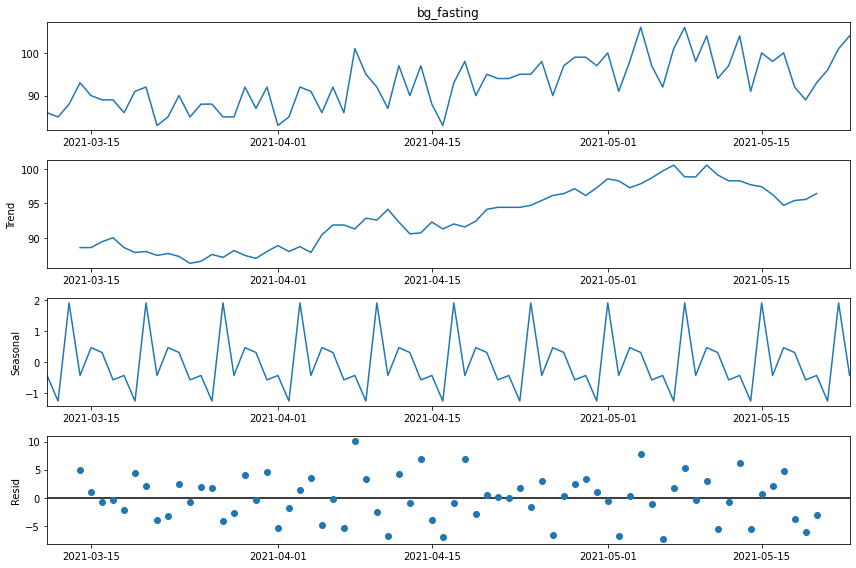

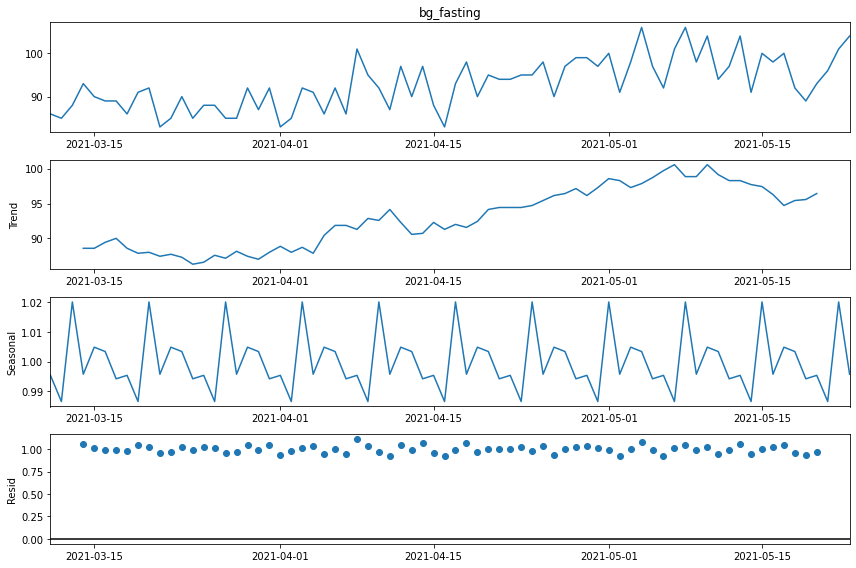

In [22]:
rcParams['figure.figsize'] = 12,8

# Plot the original data, the trend, the seasonality, and the residuals 
decomp_add = seasonal_decompose(y, model='additive')
decomp_add.plot()

decomp_mlt = seasonal_decompose(y, model='multiplicative')
decomp_mlt.plot()

plt.show()

### Stationarity

In [83]:
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(7).mean()
#     rolstd = timeseries.rolling(7).std()
#     #Plot rolling statistics:
#     fig = plt.figure(figsize=(12, 8))
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')

#     plt.axvline(pd.to_datetime('2021-05-01'), color='gray', label='med begin')
    
#     plt.savefig('vis/stationarity.png', bbox_inches="tight")
#     plt.show()
    
#      #Perform Dickey-Fuller test:
#     print( 'Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print( dfoutput) 

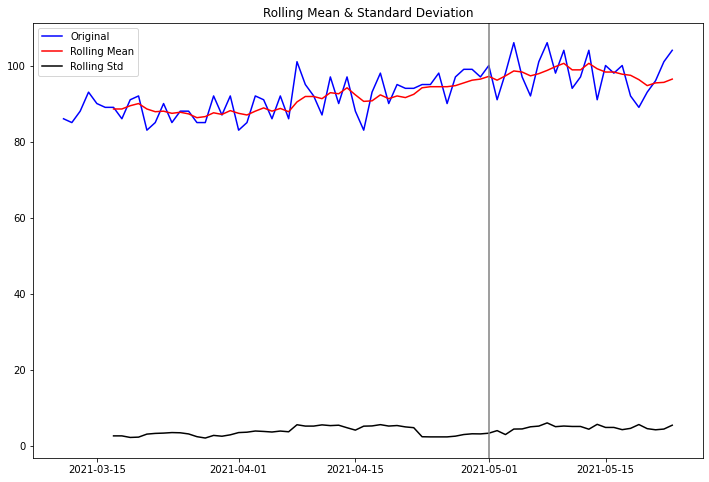

Results of Dickey-Fuller Test:
Test Statistic                 -0.829570
p-value                         0.810282
#Lags Used                      5.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [23]:
jlcap_test_stationarity(y)

Because the p-value is above .05 we cannot reject the null hypothesis that the time series is non-stationary.

In [24]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(y)
print('statistic:', statistic)
print('p_value:', p_value)
print('n_lags:', n_lags)
print('critical_values:', critical_values)

statistic: 1.3638267830641668
p_value: 0.01
n_lags: 4
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Just out of curiosity I ran my time series through the kpss test as well. It agrees that the time series is not stationary.

### ACF and PACF

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


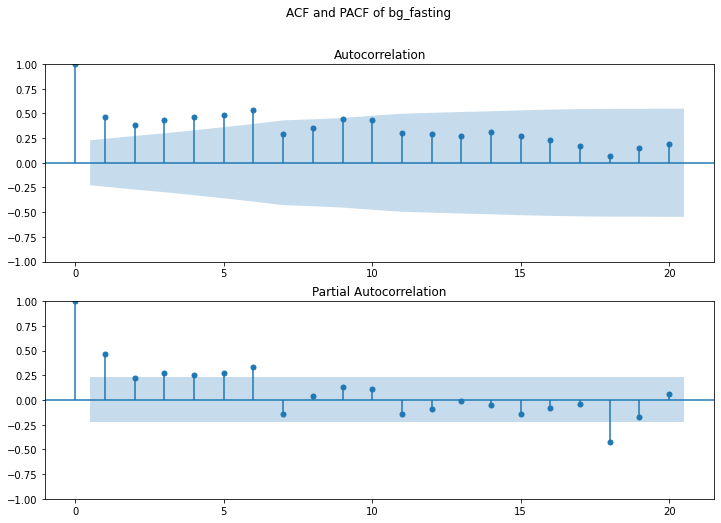

In [25]:
# Plot the ACF and PACF
fig, axes = plt.subplots(2,1)

plot_acf(y, lags=20, ax=axes[0])
plot_pacf(y, lags=20, ax=axes[1])

plt.suptitle('ACF and PACF of bg_fasting')

plt.savefig('vis/acf-pacf.png', bbox_inches="tight")
plt.show()

**Notes**

The ACF shows positive correlations for all visualized lags. According to Duke University's guide on ARIMA models this indicates that the data likely needs a higher order of differencing (Rule 1). This confirms the results of the Dickey Fuller test.

**Let's diff.**

In [36]:
y_diff = y_train.diff()
y_diff = y_diff.dropna()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


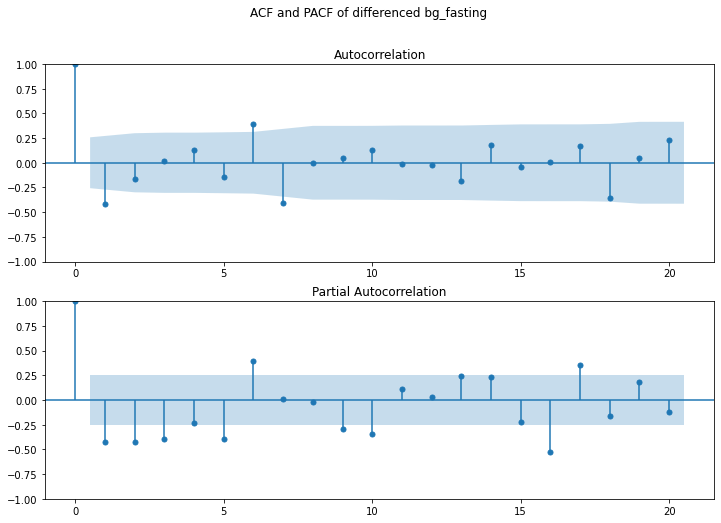

In [37]:
fig, axes = plt.subplots(2,1)

plot_acf(y_diff, lags=20, ax=axes[0])
plot_pacf(y_diff, lags=20, ax=axes[1])

plt.suptitle('ACF and PACF of differenced bg_fasting')

plt.savefig('vis/acf-pacf-diff.png', bbox_inches="tight")
plt.show()

<p>Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.</p>
<p>MA +1</p>

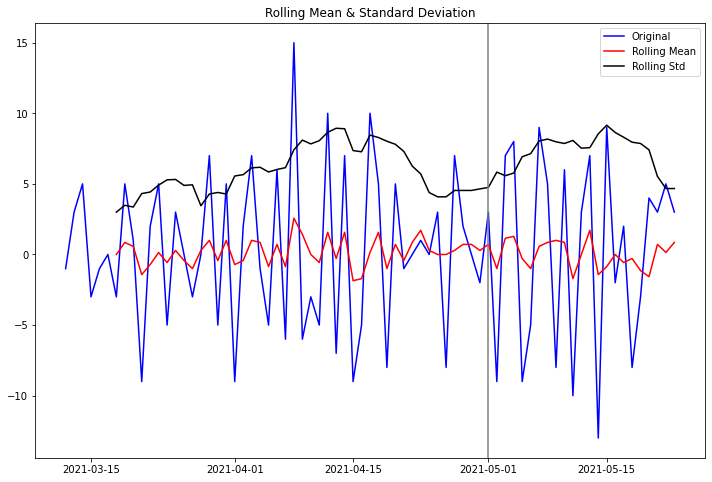

Results of Dickey-Fuller Test:
Test Statistic                -7.433254e+00
p-value                        6.279477e-11
#Lags Used                     4.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64


In [28]:
# Test the stationarity again using the differenced time series
jlcap_test_stationarity(y_diff)

We are now stationary!

### Save Stationary Data

In [49]:
datapath = 'data'
save_file(y_diff.reset_index(), 'data_stationary.csv', datapath)
save_file(y_r.reset_index(), 'data_pre-processed.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/data_stationary.csv"
Writing file.  "data/data_pre-processed.csv"


### Finding ARIMA Parameters

In [123]:
# import warnings

# warnings.filterwarnings("ignore")

# def jlcap_optimize_arima(y, ps, qs, d=1):
#     summary = []
    
#     for p in ps:
#         for q in qs:
#             try:
#                 mod = ARIMA(y, order=(p, d, q))
#                 res = mod.fit()
#                 summary.append([(p, d, q), res.aic, res.bic])
#             except:
#                 summary.append([(p, d, q), None, None])
    
#     summary_df = pd.DataFrame(summary)
#     summary_df.columns = ['Order', 'AIC', 'BIC']
#     summary_aic = summary_df[['Order', 'AIC']].sort_values('AIC').reset_index(drop=True)
#     summary_bic = summary_df[['Order', 'BIC']].sort_values('BIC').reset_index(drop=True)
    
    
#     if summary_aic.iloc[0].Order == summary_bic.iloc[0].Order:
#         print('Top performing order is the same for AIC and BIC:', summary_aic.iloc[0].Order)
#     else:
#         print('Top 3 Orders according to AIC: {} {} {}'.format(summary_aic.iloc[0].Order, summary_aic.iloc[1].Order, summary_aic.iloc[2].Order))
#         print('Top 3 Orders according to BIC: {} {} {}'.format(summary_bic.iloc[0].Order, summary_bic.iloc[1].Order, summary_bic.iloc[2].Order))

In [42]:
ps = range(0,6)
qs = range(1,6)

jlcap_optimize_arima(y_diff, ps, qs)

Top 3 Orders according to AIC: (5, 1, 4) (5, 1, 5) (5, 1, 2)
Top 3 Orders according to BIC: (0, 1, 2) (5, 1, 4) (5, 1, 5)


In [45]:
# Forecast using an ARIMA(1,1,1) model
mod = ARIMA(y, order=(5,1,4))
res = mod.fit()

print(res.summary())


                               SARIMAX Results                                
Dep. Variable:             bg_fasting   No. Observations:                   74
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -208.022
Date:                Mon, 28 Feb 2022   AIC                            436.044
Time:                        15:15:24   BIC                            458.948
Sample:                    03-11-2021   HQIC                           445.171
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2494      0.269     -4.638      0.000      -1.777      -0.721
ar.L2         -1.5733      0.292     -5.383      0.000      -2.146      -1.000
ar.L3         -1.3736      0.362     -3.798      0.0

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# Residuals
res.resid

date_forward
2021-03-11    86.000000
2021-03-12    -0.998597
2021-03-13     2.549509
2021-03-14     6.496397
2021-03-15     2.246084
2021-03-16     1.452792
2021-03-17     1.181012
2021-03-18    -3.044651
2021-03-19     1.310985
2021-03-20     1.889805
2021-03-21    -5.066381
2021-03-22    -3.116037
2021-03-23     0.747767
2021-03-24    -3.138657
2021-03-25     0.324322
2021-03-26     0.261331
2021-03-27    -0.667294
2021-03-28    -2.261300
2021-03-29     3.559908
2021-03-30     0.729903
2021-03-31     5.533401
2021-04-01    -5.837566
2021-04-02    -2.219756
2021-04-03     5.419626
2021-04-04     1.613926
2021-04-05    -2.400804
2021-04-06     4.336087
2021-04-07    -0.139952
2021-04-08    11.088540
2021-04-09     2.244204
2021-04-10     2.641593
2021-04-11    -1.800214
2021-04-12     3.081112
2021-04-13    -3.711428
2021-04-14     3.716624
2021-04-15    -2.776108
2021-04-16    -9.238713
2021-04-17     1.603300
2021-04-18     5.005407
2021-04-19     0.156547
2021-04-20     2.441538
202

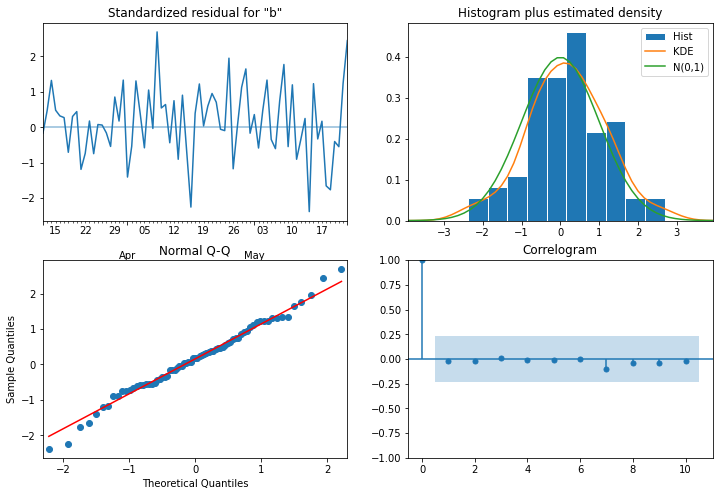

In [47]:
res.plot_diagnostics()
plt.show()

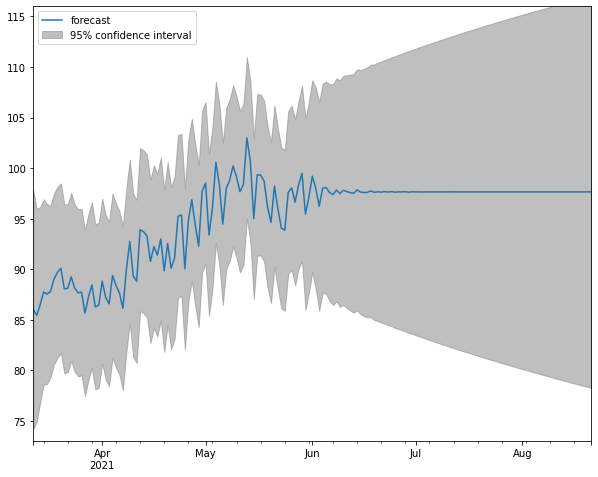

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.ylim(y.min()-10, y.max()+10)

fig = plot_predict(res, start="2021-03-12", end="2021-08-21", ax=ax)
legend = ax.legend(loc="upper left")

In [33]:
res